# Partial Default Simulation and Plots

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate() 
using Revise

In [2]:
includet(joinpath(@__DIR__, "..", "src", "partial_default.jl"));

## Example 

In [3]:
m = FixedHaircutsModel(
    bmin = 0.01,
    η_grid = [0.25, 0.75], 
    θn = [0.005, 0.005] 
)

FixedHaircutsModel{Float64, Vector{Float64}, Vector{Float64}, Int64}
  r: Float64 0.15
  i: Float64 0.01
  λ: Float64 0.2
  δ: Float64 0.02
  ϵ: Float64 0.01
  y: Float64 1.0
  bmax: Float64 1.0
  η_grid: Array{Float64}((2,)) [0.25, 0.75]
  θn: Array{Float64}((2,)) [0.005, 0.005]
  max_n: Int64 2
  bmin: Float64 0.01


In [4]:
sol = solve(m, c_range = BigFloat[1.002, 1.05]);

..............................................................................................................................................................................................................................................................

In [5]:
sol.T

30.87828187255266602707736711374720817779543405127269854745214444389359297341834

In [6]:
sol.cstar

1.002633828143268132914236719665671260555606699375521372223562270200950158031296

## Plots

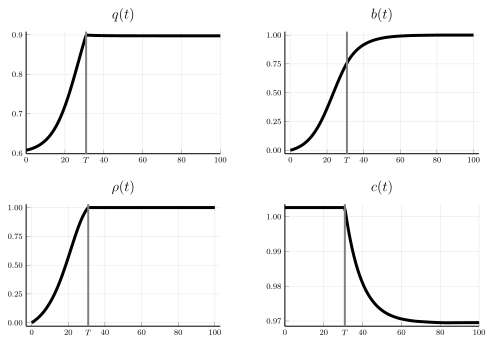

In [7]:
f1 = do_plots(sol)

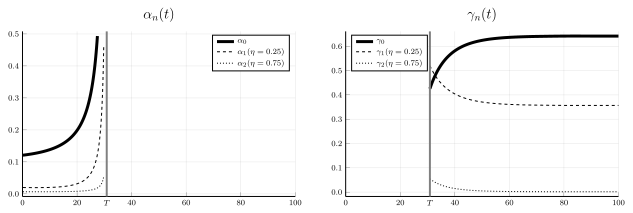

In [8]:
f2 = do_conditional_default_probability_plots(sol)

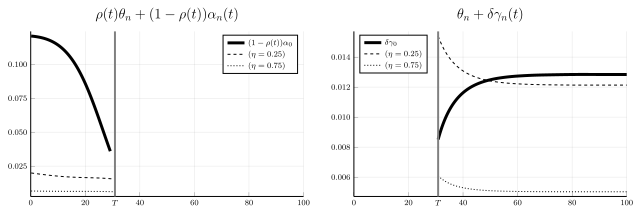

In [9]:
f3 = do_unconditional_default_probability_plots(sol)

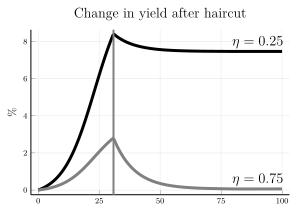

In [10]:
f4 = do_increase_in_yield_plots(sol)

### Exporting figures

In [11]:
savefig(f1, joinpath(@__DIR__, "..", "output", "basic_plot.pdf"))
savefig(f2, joinpath(@__DIR__, "..", "output", "conditional_plot.pdf"))
savefig(f3, joinpath(@__DIR__, "..", "output", "unconditional_plot.pdf"))
savefig(f4, joinpath(@__DIR__, "..", "output", "yields_plot.pdf"))